In [3]:
import time 
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, SimpleRNN, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
tf.compat.v1.disable_eager_execution()
from scipy.integrate import odeint
from scipy.optimize import minimize,Bounds
from sklearn.preprocessing import MinMaxScaler

from utils import ode_function, signal_generator, data_prep

# Nonlinear Model Predictive Control Using Identified Neural Network Model
In this notebook, using the power of tensorflow a feed forward neural network model for input and output data of a polymerization reactor is identified and then by using the nonlinear neural model in the form of NARX a nonlinear MPC is implemented to control the process.   

## Identification Using a  Neural Network Model

In [4]:
def ode_model_simulator(dt, x0, ode_function):

    x = x0
    t = 0
    while True:
        u = yield x
        x = odeint(ode_function,x,[t,t+dt],args=(u,))[-1]
        t += dt

In [66]:
# 1. select sample time and get initial condition
t_f = 200
dt = 0.02
x0 = np.array([ 5.37459607e+00, 2.24331334e-01, 3.13082074e-03, 6.26162513e+01 ])
u0 = 0.028328
t = np.arange(0,t_f,dt)
np.random.seed(120)
# 2. create a process instance
model = ode_model_simulator(dt, x0, ode_function)

# 3. input generation 
x_id = [model.send(None)]

# x_id = []
u_id = u0 + signal_generator(int(t_f/dt),(-0.8*u0, 0.8*u0),(0.2/dt,3/dt))
u_id[0:40] = 0.028328

# 4. append subsequent states
x_id += [ model.send(u_id[i+1]) for i in range(int(t_f/dt)-1) ]
x_id = np.stack(x_id)

# output of the system
y_id = x_id[:,3]/x_id[:,2]/10000

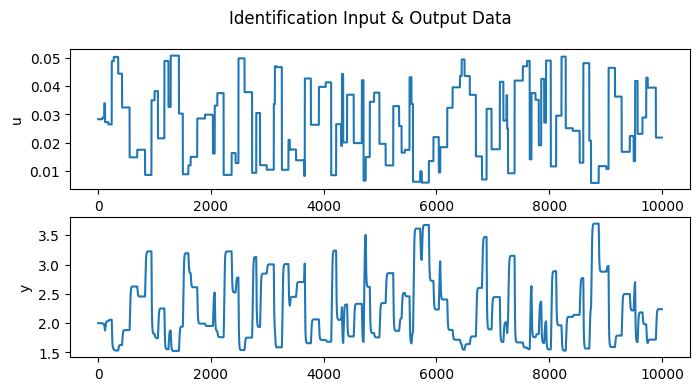

In [67]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('Identification Input & Output Data')
plt.subplot(2,1,1); plt.ylabel('u')
plt.plot(u_id)
plt.subplot(2,1,2); plt.ylabel('y')
plt.plot(y_id);

In [68]:
# data normalizatoin using min/max scaling
s1 = MinMaxScaler(feature_range=(-1,1))
s2 = MinMaxScaler(feature_range=(-1,1))

u_id_scaled = s1.fit_transform(u_id.reshape(-1,1))
y_id_scaled = s2.fit_transform(y_id.reshape(-1,1))

scalers = {'s1': s1, 's2': s2}

# Save the scalers to a file
with open('scalers.pkl', 'wb') as file:
    pickle.dump(scalers, file)

In [69]:
# preparation of data in a way to be handled for training using tf/keras
window = 2
X_train, X_val, Y_train, Y_val = data_prep(u_id_scaled,y_id_scaled, window = window)

In [76]:
# feed forward neural network
model_ff = Sequential(name='NARX')
model_ff.add(Flatten(input_shape=(window, u_id_scaled.shape[1]+y_id_scaled.shape[1])))
model_ff.add(Dense(units=5, activation='tanh'))
model_ff.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model_ff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),\
                 loss = 'mse', metrics = ['mae'])

# for early exit
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=100)

In [77]:
# Fit model
t0 = time.time()
history = model_ff.fit(X_train, Y_train, epochs = 2000, batch_size = 64, 
                    callbacks=[es], verbose=1, validation_data=(X_val, Y_val));
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Train on 7000 samples, validate on 2998 samples
Epoch 1/2000
7000/7000 [==============================] - 0s 23us/sample - loss: 0.5383 - mae: 0.6629 - val_loss: 0.3944 - val_mae: 0.5786
Epoch 2/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 0.2389 - mae: 0.4409 - val_loss: 0.1704 - val_mae: 0.3662
Epoch 3/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 0.1020 - mae: 0.2754 - val_loss: 0.0773 - val_mae: 0.2184
Epoch 4/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 0.0506 - mae: 0.1692 - val_loss: 0.0460 - val_mae: 0.1399
Epoch 5/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 0.0347 - mae: 0.1210 - val_loss: 0.0359 - val_mae: 0.1176
Epoch 6/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 0.0287 - mae: 0.1029 - val_loss: 0.0307 - val_mae: 0.1070
Epoch 7/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 0.0248 - mae: 0.0932 - val_loss: 0.0265 - v

7000/7000 [==============================] - 0s 8us/sample - loss: 2.0348e-04 - mae: 0.0092 - val_loss: 2.7050e-04 - val_mae: 0.0103
Epoch 59/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.9929e-04 - mae: 0.0091 - val_loss: 2.7026e-04 - val_mae: 0.0104
Epoch 60/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.9570e-04 - mae: 0.0090 - val_loss: 2.6076e-04 - val_mae: 0.0100
Epoch 61/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.9254e-04 - mae: 0.0090 - val_loss: 2.5929e-04 - val_mae: 0.0100
Epoch 62/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.8951e-04 - mae: 0.0089 - val_loss: 2.5214e-04 - val_mae: 0.0100
Epoch 63/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.8542e-04 - mae: 0.0088 - val_loss: 2.5291e-04 - val_mae: 0.0098
Epoch 64/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.8172e-04 - mae: 0.0087 - val_loss: 2.4869e-04 - v

Epoch 114/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.0673e-05 - mae: 0.0050 - val_loss: 8.2491e-05 - val_mae: 0.0053
Epoch 115/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.9425e-05 - mae: 0.0049 - val_loss: 8.2229e-05 - val_mae: 0.0052
Epoch 116/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.8734e-05 - mae: 0.0049 - val_loss: 8.3949e-05 - val_mae: 0.0065
Epoch 117/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.6552e-05 - mae: 0.0048 - val_loss: 7.8975e-05 - val_mae: 0.0056
Epoch 118/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 5.6540e-05 - mae: 0.0049 - val_loss: 7.5059e-05 - val_mae: 0.0050
Epoch 119/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4606e-05 - mae: 0.0047 - val_loss: 7.3768e-05 - val_mae: 0.0052
Epoch 120/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4308e-05 - mae: 0.0048 - val

7000/7000 [==============================] - 0s 10us/sample - loss: 2.6189e-05 - mae: 0.0032 - val_loss: 3.6858e-05 - val_mae: 0.0043
Epoch 170/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 2.6556e-05 - mae: 0.0033 - val_loss: 3.4841e-05 - val_mae: 0.0036
Epoch 171/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 2.6055e-05 - mae: 0.0033 - val_loss: 3.4388e-05 - val_mae: 0.0037
Epoch 172/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 2.5480e-05 - mae: 0.0032 - val_loss: 3.5893e-05 - val_mae: 0.0033
Epoch 173/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 2.5210e-05 - mae: 0.0032 - val_loss: 3.3669e-05 - val_mae: 0.0034
Epoch 174/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 2.5310e-05 - mae: 0.0032 - val_loss: 3.4284e-05 - val_mae: 0.0037
Epoch 175/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 2.5156e-05 - mae: 0.0032 - val_loss: 3.5465

7000/7000 [==============================] - 0s 8us/sample - loss: 1.7585e-05 - mae: 0.0026 - val_loss: 2.5202e-05 - val_mae: 0.0030
Epoch 225/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.7989e-05 - mae: 0.0027 - val_loss: 2.5600e-05 - val_mae: 0.0029
Epoch 226/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.7752e-05 - mae: 0.0026 - val_loss: 2.2791e-05 - val_mae: 0.0028
Epoch 227/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.7547e-05 - mae: 0.0026 - val_loss: 2.4027e-05 - val_mae: 0.0028
Epoch 228/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.8034e-05 - mae: 0.0026 - val_loss: 2.3988e-05 - val_mae: 0.0029
Epoch 229/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.7500e-05 - mae: 0.0026 - val_loss: 2.4554e-05 - val_mae: 0.0034
Epoch 230/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.7542e-05 - mae: 0.0026 - val_loss: 2.4301e-

7000/7000 [==============================] - 0s 8us/sample - loss: 1.5863e-05 - mae: 0.0024 - val_loss: 2.0123e-05 - val_mae: 0.0024
Epoch 280/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.5298e-05 - mae: 0.0024 - val_loss: 1.9134e-05 - val_mae: 0.0026
Epoch 281/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 1.5245e-05 - mae: 0.0024 - val_loss: 1.9964e-05 - val_mae: 0.0025
Epoch 282/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.5073e-05 - mae: 0.0023 - val_loss: 1.8985e-05 - val_mae: 0.0024
Epoch 283/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 1.5252e-05 - mae: 0.0024 - val_loss: 2.6203e-05 - val_mae: 0.0035
Epoch 284/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 1.5158e-05 - mae: 0.0024 - val_loss: 1.9381e-05 - val_mae: 0.0024
Epoch 285/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 1.5608e-05 - mae: 0.0024 - val_loss: 1.8903e

7000/7000 [==============================] - 0s 9us/sample - loss: 1.3389e-05 - mae: 0.0022 - val_loss: 1.7357e-05 - val_mae: 0.0024
Epoch 335/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.3995e-05 - mae: 0.0022 - val_loss: 1.7629e-05 - val_mae: 0.0024
Epoch 336/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.3363e-05 - mae: 0.0022 - val_loss: 1.9703e-05 - val_mae: 0.0024
Epoch 337/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.3879e-05 - mae: 0.0022 - val_loss: 1.9364e-05 - val_mae: 0.0023
Epoch 338/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.3479e-05 - mae: 0.0021 - val_loss: 1.7362e-05 - val_mae: 0.0023
Epoch 339/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.4196e-05 - mae: 0.0023 - val_loss: 1.6261e-05 - val_mae: 0.0022
Epoch 340/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.3698e-05 - mae: 0.0022 - val_loss: 1.6208e-

7000/7000 [==============================] - 0s 7us/sample - loss: 1.2583e-05 - mae: 0.0021 - val_loss: 1.6987e-05 - val_mae: 0.0023
Epoch 390/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 1.3053e-05 - mae: 0.0021 - val_loss: 1.7757e-05 - val_mae: 0.0022
Epoch 391/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.2435e-05 - mae: 0.0020 - val_loss: 1.9425e-05 - val_mae: 0.0027
Epoch 392/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 1.2941e-05 - mae: 0.0021 - val_loss: 1.7754e-05 - val_mae: 0.0021
Epoch 393/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 1.3087e-05 - mae: 0.0021 - val_loss: 1.6648e-05 - val_mae: 0.0023
Epoch 394/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 1.3004e-05 - mae: 0.0021 - val_loss: 1.9355e-05 - val_mae: 0.0028
Epoch 395/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.3193e-05 - mae: 0.0021 - val_loss: 1.5627

7000/7000 [==============================] - 0s 8us/sample - loss: 1.2693e-05 - mae: 0.0021 - val_loss: 1.8948e-05 - val_mae: 0.0024
Epoch 445/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.2090e-05 - mae: 0.0020 - val_loss: 1.6037e-05 - val_mae: 0.0023
Epoch 446/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.2341e-05 - mae: 0.0020 - val_loss: 1.4716e-05 - val_mae: 0.0020
Epoch 447/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.1666e-05 - mae: 0.0019 - val_loss: 1.5005e-05 - val_mae: 0.0022
Epoch 448/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.1949e-05 - mae: 0.0020 - val_loss: 1.4366e-05 - val_mae: 0.0021
Epoch 449/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.2006e-05 - mae: 0.0020 - val_loss: 1.7239e-05 - val_mae: 0.0027
Epoch 450/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.1710e-05 - mae: 0.0019 - val_loss: 1.6183e-

7000/7000 [==============================] - 0s 9us/sample - loss: 1.2046e-05 - mae: 0.0020 - val_loss: 1.4223e-05 - val_mae: 0.0019
Epoch 500/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 1.1454e-05 - mae: 0.0019 - val_loss: 1.7015e-05 - val_mae: 0.0025
Epoch 501/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 1.1985e-05 - mae: 0.0020 - val_loss: 1.4242e-05 - val_mae: 0.0021
Epoch 502/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 1.1133e-05 - mae: 0.0019 - val_loss: 1.4700e-05 - val_mae: 0.0020
Epoch 503/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 1.1462e-05 - mae: 0.0020 - val_loss: 1.4298e-05 - val_mae: 0.0019
Epoch 504/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 1.1592e-05 - mae: 0.0020 - val_loss: 1.6715e-05 - val_mae: 0.0027
Epoch 505/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.1629e-05 - mae: 0.0020 - val_loss: 1.3932

7000/7000 [==============================] - 0s 8us/sample - loss: 1.1222e-05 - mae: 0.0019 - val_loss: 1.5272e-05 - val_mae: 0.0022
Epoch 555/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.1600e-05 - mae: 0.0020 - val_loss: 1.4084e-05 - val_mae: 0.0021
Epoch 556/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.2198e-05 - mae: 0.0021 - val_loss: 1.5127e-05 - val_mae: 0.0019
Epoch 557/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.1037e-05 - mae: 0.0019 - val_loss: 1.4073e-05 - val_mae: 0.0021
Epoch 558/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.1145e-05 - mae: 0.0019 - val_loss: 1.6134e-05 - val_mae: 0.0022
Epoch 559/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0826e-05 - mae: 0.0019 - val_loss: 1.3942e-05 - val_mae: 0.0022
Epoch 560/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.1208e-05 - mae: 0.0019 - val_loss: 1.4373e-

7000/7000 [==============================] - 0s 8us/sample - loss: 1.0934e-05 - mae: 0.0019 - val_loss: 1.3996e-05 - val_mae: 0.0022
Epoch 610/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0646e-05 - mae: 0.0019 - val_loss: 1.3120e-05 - val_mae: 0.0018
Epoch 611/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0640e-05 - mae: 0.0019 - val_loss: 1.3842e-05 - val_mae: 0.0019
Epoch 612/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0377e-05 - mae: 0.0018 - val_loss: 1.3459e-05 - val_mae: 0.0019
Epoch 613/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0539e-05 - mae: 0.0018 - val_loss: 1.4263e-05 - val_mae: 0.0020
Epoch 614/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0238e-05 - mae: 0.0018 - val_loss: 1.2842e-05 - val_mae: 0.0019
Epoch 615/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.1134e-05 - mae: 0.0019 - val_loss: 1.4097e-

7000/7000 [==============================] - 0s 8us/sample - loss: 1.0266e-05 - mae: 0.0019 - val_loss: 1.6737e-05 - val_mae: 0.0026
Epoch 665/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.0284e-05 - mae: 0.0018 - val_loss: 1.3203e-05 - val_mae: 0.0021
Epoch 666/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0615e-05 - mae: 0.0019 - val_loss: 1.2034e-05 - val_mae: 0.0018
Epoch 667/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.0345e-05 - mae: 0.0019 - val_loss: 1.3622e-05 - val_mae: 0.0021
Epoch 668/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.0568e-05 - mae: 0.0019 - val_loss: 1.5887e-05 - val_mae: 0.0024
Epoch 669/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 1.0400e-05 - mae: 0.0018 - val_loss: 1.4131e-05 - val_mae: 0.0021
Epoch 670/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0324e-05 - mae: 0.0018 - val_loss: 1.4655e-

7000/7000 [==============================] - 0s 8us/sample - loss: 9.9360e-06 - mae: 0.0018 - val_loss: 1.2488e-05 - val_mae: 0.0018
Epoch 720/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 1.0059e-05 - mae: 0.0018 - val_loss: 1.1997e-05 - val_mae: 0.0018
Epoch 721/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 9.8859e-06 - mae: 0.0018 - val_loss: 1.3493e-05 - val_mae: 0.0020
Epoch 722/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 9.9218e-06 - mae: 0.0018 - val_loss: 1.3013e-05 - val_mae: 0.0019
Epoch 723/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0368e-05 - mae: 0.0018 - val_loss: 1.2798e-05 - val_mae: 0.0020
Epoch 724/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 9.6930e-06 - mae: 0.0018 - val_loss: 2.2072e-05 - val_mae: 0.0032
Epoch 725/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0184e-05 - mae: 0.0018 - val_loss: 1.2057e

7000/7000 [==============================] - 0s 9us/sample - loss: 9.4262e-06 - mae: 0.0017 - val_loss: 1.3619e-05 - val_mae: 0.0020
Epoch 775/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 9.5527e-06 - mae: 0.0018 - val_loss: 1.1518e-05 - val_mae: 0.0017
Epoch 776/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 9.4688e-06 - mae: 0.0017 - val_loss: 1.1789e-05 - val_mae: 0.0018
Epoch 777/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 1.0045e-05 - mae: 0.0018 - val_loss: 1.1845e-05 - val_mae: 0.0018
Epoch 778/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 9.8206e-06 - mae: 0.0018 - val_loss: 1.3904e-05 - val_mae: 0.0023
Epoch 779/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 9.8317e-06 - mae: 0.0018 - val_loss: 1.2373e-05 - val_mae: 0.0018
Epoch 780/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 9.7358e-06 - mae: 0.0018 - val_loss: 1.1493e-

7000/7000 [==============================] - 0s 8us/sample - loss: 9.7777e-06 - mae: 0.0018 - val_loss: 1.1908e-05 - val_mae: 0.0017
Epoch 830/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 9.4768e-06 - mae: 0.0017 - val_loss: 1.2456e-05 - val_mae: 0.0019
Epoch 831/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 9.4531e-06 - mae: 0.0018 - val_loss: 1.1823e-05 - val_mae: 0.0017
Epoch 832/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 9.4078e-06 - mae: 0.0018 - val_loss: 1.1792e-05 - val_mae: 0.0017
Epoch 833/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 9.9810e-06 - mae: 0.0018 - val_loss: 1.0803e-05 - val_mae: 0.0017
Epoch 834/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 9.0619e-06 - mae: 0.0017 - val_loss: 1.5641e-05 - val_mae: 0.0023
Epoch 835/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 9.5565e-06 - mae: 0.0018 - val_loss: 1.1202e-

7000/7000 [==============================] - 0s 8us/sample - loss: 9.0545e-06 - mae: 0.0017 - val_loss: 1.1373e-05 - val_mae: 0.0019
Epoch 885/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 9.3369e-06 - mae: 0.0017 - val_loss: 1.2622e-05 - val_mae: 0.0021
Epoch 886/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 8.9302e-06 - mae: 0.0017 - val_loss: 2.0704e-05 - val_mae: 0.0032
Epoch 887/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 9.6927e-06 - mae: 0.0018 - val_loss: 1.1084e-05 - val_mae: 0.0018
Epoch 888/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 8.8733e-06 - mae: 0.0017 - val_loss: 1.3747e-05 - val_mae: 0.0024
Epoch 889/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 9.3138e-06 - mae: 0.0017 - val_loss: 1.1371e-05 - val_mae: 0.0016
Epoch 890/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 8.7194e-06 - mae: 0.0016 - val_loss: 1.2820e

7000/7000 [==============================] - 0s 10us/sample - loss: 8.6374e-06 - mae: 0.0016 - val_loss: 1.1784e-05 - val_mae: 0.0019
Epoch 940/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.5419e-06 - mae: 0.0016 - val_loss: 1.4155e-05 - val_mae: 0.0021
Epoch 941/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 9.0161e-06 - mae: 0.0017 - val_loss: 1.1205e-05 - val_mae: 0.0018
Epoch 942/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.7234e-06 - mae: 0.0016 - val_loss: 1.1847e-05 - val_mae: 0.0020
Epoch 943/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.4575e-06 - mae: 0.0016 - val_loss: 2.0369e-05 - val_mae: 0.0032
Epoch 944/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 9.1875e-06 - mae: 0.0017 - val_loss: 1.1872e-05 - val_mae: 0.0018
Epoch 945/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.7772e-06 - mae: 0.0017 - val_loss: 1.1149e

7000/7000 [==============================] - 0s 9us/sample - loss: 8.5538e-06 - mae: 0.0016 - val_loss: 1.0377e-05 - val_mae: 0.0016
Epoch 995/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 8.0168e-06 - mae: 0.0015 - val_loss: 1.1237e-05 - val_mae: 0.0018
Epoch 996/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 8.3019e-06 - mae: 0.0016 - val_loss: 1.0053e-05 - val_mae: 0.0016
Epoch 997/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 8.3067e-06 - mae: 0.0016 - val_loss: 1.0281e-05 - val_mae: 0.0017
Epoch 998/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 8.7481e-06 - mae: 0.0017 - val_loss: 1.1276e-05 - val_mae: 0.0017
Epoch 999/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 8.6033e-06 - mae: 0.0016 - val_loss: 1.1727e-05 - val_mae: 0.0021
Epoch 1000/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 8.1802e-06 - mae: 0.0016 - val_loss: 1.1432

7000/7000 [==============================] - 0s 9us/sample - loss: 8.2971e-06 - mae: 0.0016 - val_loss: 1.1164e-05 - val_mae: 0.0017
Epoch 1050/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.0880e-06 - mae: 0.0016 - val_loss: 9.9703e-06 - val_mae: 0.0015
Epoch 1051/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.3563e-06 - mae: 0.0016 - val_loss: 1.2750e-05 - val_mae: 0.0021
Epoch 1052/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.2293e-06 - mae: 0.0016 - val_loss: 1.0112e-05 - val_mae: 0.0015
Epoch 1053/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.2125e-06 - mae: 0.0016 - val_loss: 1.0416e-05 - val_mae: 0.0016
Epoch 1054/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.2356e-06 - mae: 0.0016 - val_loss: 1.0853e-05 - val_mae: 0.0018
Epoch 1055/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.9488e-06 - mae: 0.0015 - val_loss: 1.

7000/7000 [==============================] - 0s 9us/sample - loss: 7.8833e-06 - mae: 0.0015 - val_loss: 1.0952e-05 - val_mae: 0.0016
Epoch 1105/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.2209e-06 - mae: 0.0016 - val_loss: 9.5967e-06 - val_mae: 0.0015
Epoch 1106/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 7.7995e-06 - mae: 0.0015 - val_loss: 9.9402e-06 - val_mae: 0.0015
Epoch 1107/2000
7000/7000 [==============================] - 0s 11us/sample - loss: 8.1679e-06 - mae: 0.0016 - val_loss: 1.1215e-05 - val_mae: 0.0020
Epoch 1108/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.0319e-06 - mae: 0.0016 - val_loss: 1.0319e-05 - val_mae: 0.0016
Epoch 1109/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 7.7282e-06 - mae: 0.0015 - val_loss: 1.0256e-05 - val_mae: 0.0018
Epoch 1110/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.9922e-06 - mae: 0.0016 - val_loss: 1

7000/7000 [==============================] - 0s 8us/sample - loss: 7.9255e-06 - mae: 0.0016 - val_loss: 9.7227e-06 - val_mae: 0.0016
Epoch 1160/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 7.7614e-06 - mae: 0.0015 - val_loss: 1.4231e-05 - val_mae: 0.0025
Epoch 1161/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 8.0052e-06 - mae: 0.0016 - val_loss: 9.9486e-06 - val_mae: 0.0016
Epoch 1162/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.7700e-06 - mae: 0.0016 - val_loss: 9.5535e-06 - val_mae: 0.0016
Epoch 1163/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.2665e-06 - mae: 0.0014 - val_loss: 1.0522e-05 - val_mae: 0.0016
Epoch 1164/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.9198e-06 - mae: 0.0016 - val_loss: 1.0490e-05 - val_mae: 0.0018
Epoch 1165/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.7203e-06 - mae: 0.0015 - val_loss: 9.

7000/7000 [==============================] - 0s 9us/sample - loss: 7.8261e-06 - mae: 0.0016 - val_loss: 8.8626e-06 - val_mae: 0.0014
Epoch 1215/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.5950e-06 - mae: 0.0015 - val_loss: 9.6256e-06 - val_mae: 0.0014
Epoch 1216/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 7.9999e-06 - mae: 0.0016 - val_loss: 1.0113e-05 - val_mae: 0.0018
Epoch 1217/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.2549e-06 - mae: 0.0014 - val_loss: 9.1784e-06 - val_mae: 0.0014
Epoch 1218/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 7.4453e-06 - mae: 0.0015 - val_loss: 9.2052e-06 - val_mae: 0.0014
Epoch 1219/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.0083e-06 - mae: 0.0014 - val_loss: 9.1534e-06 - val_mae: 0.0015
Epoch 1220/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 7.3252e-06 - mae: 0.0014 - val_loss: 1.

7000/7000 [==============================] - 0s 8us/sample - loss: 6.8934e-06 - mae: 0.0014 - val_loss: 9.4919e-06 - val_mae: 0.0015
Epoch 1270/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.9780e-06 - mae: 0.0014 - val_loss: 1.1482e-05 - val_mae: 0.0023
Epoch 1271/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.5488e-06 - mae: 0.0015 - val_loss: 1.0505e-05 - val_mae: 0.0019
Epoch 1272/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.3975e-06 - mae: 0.0015 - val_loss: 1.0072e-05 - val_mae: 0.0017
Epoch 1273/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.2526e-06 - mae: 0.0014 - val_loss: 1.0456e-05 - val_mae: 0.0020
Epoch 1274/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.1833e-06 - mae: 0.0014 - val_loss: 8.6243e-06 - val_mae: 0.0014
Epoch 1275/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.9547e-06 - mae: 0.0014 - val_loss: 9.

7000/7000 [==============================] - 0s 8us/sample - loss: 6.7485e-06 - mae: 0.0014 - val_loss: 9.9481e-06 - val_mae: 0.0016
Epoch 1325/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.6915e-06 - mae: 0.0013 - val_loss: 8.4396e-06 - val_mae: 0.0013
Epoch 1326/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.8226e-06 - mae: 0.0014 - val_loss: 8.4313e-06 - val_mae: 0.0015
Epoch 1327/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.0178e-06 - mae: 0.0014 - val_loss: 9.3039e-06 - val_mae: 0.0014
Epoch 1328/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.7948e-06 - mae: 0.0014 - val_loss: 1.0685e-05 - val_mae: 0.0021
Epoch 1329/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.6010e-06 - mae: 0.0013 - val_loss: 8.5903e-06 - val_mae: 0.0015
Epoch 1330/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.1375e-06 - mae: 0.0014 - val_loss: 8.

7000/7000 [==============================] - 0s 9us/sample - loss: 6.3580e-06 - mae: 0.0013 - val_loss: 8.9343e-06 - val_mae: 0.0014
Epoch 1380/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.4984e-06 - mae: 0.0013 - val_loss: 7.8466e-06 - val_mae: 0.0012
Epoch 1381/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.5711e-06 - mae: 0.0013 - val_loss: 1.0561e-05 - val_mae: 0.0018
Epoch 1382/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.6402e-06 - mae: 0.0013 - val_loss: 8.2796e-06 - val_mae: 0.0013
Epoch 1383/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.6830e-06 - mae: 0.0013 - val_loss: 9.2337e-06 - val_mae: 0.0017
Epoch 1384/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 6.4275e-06 - mae: 0.0013 - val_loss: 8.3365e-06 - val_mae: 0.0015
Epoch 1385/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.3057e-06 - mae: 0.0012 - val_loss: 8.

7000/7000 [==============================] - 0s 8us/sample - loss: 6.7204e-06 - mae: 0.0014 - val_loss: 7.7473e-06 - val_mae: 0.0014
Epoch 1435/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 6.0446e-06 - mae: 0.0012 - val_loss: 7.9284e-06 - val_mae: 0.0012
Epoch 1436/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.0357e-06 - mae: 0.0012 - val_loss: 7.9099e-06 - val_mae: 0.0014
Epoch 1437/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.3496e-06 - mae: 0.0013 - val_loss: 7.8057e-06 - val_mae: 0.0013
Epoch 1438/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.4917e-06 - mae: 0.0013 - val_loss: 7.2149e-06 - val_mae: 0.0011
Epoch 1439/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.4750e-06 - mae: 0.0013 - val_loss: 7.7730e-06 - val_mae: 0.0013
Epoch 1440/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.4104e-06 - mae: 0.0013 - val_loss: 7.

7000/7000 [==============================] - 0s 8us/sample - loss: 6.0045e-06 - mae: 0.0012 - val_loss: 7.4421e-06 - val_mae: 0.0012
Epoch 1490/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.0406e-06 - mae: 0.0012 - val_loss: 7.8332e-06 - val_mae: 0.0013
Epoch 1491/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 6.2955e-06 - mae: 0.0012 - val_loss: 7.5269e-06 - val_mae: 0.0013
Epoch 1492/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.7968e-06 - mae: 0.0011 - val_loss: 7.5979e-06 - val_mae: 0.0013
Epoch 1493/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.3145e-06 - mae: 0.0013 - val_loss: 7.7652e-06 - val_mae: 0.0014
Epoch 1494/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.3628e-06 - mae: 0.0013 - val_loss: 1.1781e-05 - val_mae: 0.0021
Epoch 1495/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 6.4772e-06 - mae: 0.0013 - val_loss: 6.

7000/7000 [==============================] - 0s 8us/sample - loss: 6.3914e-06 - mae: 0.0013 - val_loss: 6.8307e-06 - val_mae: 0.0011
Epoch 1545/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 5.9887e-06 - mae: 0.0012 - val_loss: 8.8321e-06 - val_mae: 0.0015
Epoch 1546/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4192e-06 - mae: 0.0010 - val_loss: 6.8595e-06 - val_mae: 0.0010
Epoch 1547/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.9649e-06 - mae: 0.0012 - val_loss: 9.4801e-06 - val_mae: 0.0016
Epoch 1548/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.7986e-06 - mae: 0.0011 - val_loss: 7.4541e-06 - val_mae: 0.0013
Epoch 1549/2000
7000/7000 [==============================] - 0s 7us/sample - loss: 5.9364e-06 - mae: 0.0012 - val_loss: 6.9096e-06 - val_mae: 0.0010
Epoch 1550/2000
7000/7000 [==============================] - 0s 10us/sample - loss: 5.7933e-06 - mae: 0.0011 - val_loss: 1

Epoch 1599/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.5521e-06 - mae: 0.0011 - val_loss: 6.6476e-06 - val_mae: 0.0010
Epoch 1600/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4708e-06 - mae: 0.0010 - val_loss: 7.0808e-06 - val_mae: 0.0013
Epoch 1601/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.9541e-06 - mae: 0.0012 - val_loss: 6.7996e-06 - val_mae: 0.0010
Epoch 1602/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.6290e-06 - mae: 0.0011 - val_loss: 9.3828e-06 - val_mae: 0.0017
Epoch 1603/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.7476e-06 - mae: 0.0012 - val_loss: 6.5895e-06 - val_mae: 9.9249e-04
Epoch 1604/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4707e-06 - mae: 0.0010 - val_loss: 7.4722e-06 - val_mae: 0.0012
Epoch 1605/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.6765e-06 - mae: 0

7000/7000 [==============================] - 0s 8us/sample - loss: 5.4746e-06 - mae: 0.0011 - val_loss: 6.7014e-06 - val_mae: 0.0011
Epoch 1654/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4668e-06 - mae: 0.0011 - val_loss: 7.4641e-06 - val_mae: 0.0013
Epoch 1655/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 6.0807e-06 - mae: 0.0012 - val_loss: 6.8855e-06 - val_mae: 0.0012
Epoch 1656/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.5848e-06 - mae: 0.0011 - val_loss: 6.7889e-06 - val_mae: 0.0011
Epoch 1657/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.3947e-06 - mae: 9.9016e-04 - val_loss: 6.3592e-06 - val_mae: 9.7615e-04
Epoch 1658/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.3505e-06 - mae: 0.0010 - val_loss: 7.4503e-06 - val_mae: 0.0014
Epoch 1659/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.9473e-06 - mae: 0.0012 - val_

7000/7000 [==============================] - 0s 8us/sample - loss: 5.5489e-06 - mae: 0.0011 - val_loss: 6.7424e-06 - val_mae: 0.0011
Epoch 1708/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 5.3035e-06 - mae: 9.7692e-04 - val_loss: 6.2149e-06 - val_mae: 9.0740e-04
Epoch 1709/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.7711e-06 - mae: 0.0012 - val_loss: 6.5454e-06 - val_mae: 0.0010
Epoch 1710/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.7065e-06 - mae: 0.0011 - val_loss: 1.0694e-05 - val_mae: 0.0021
Epoch 1711/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.5867e-06 - mae: 0.0011 - val_loss: 6.2783e-06 - val_mae: 9.7107e-04
Epoch 1712/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.6333e-06 - mae: 0.0011 - val_loss: 6.7536e-06 - val_mae: 0.0012
Epoch 1713/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.3037e-06 - mae: 0.0010 - 

7000/7000 [==============================] - 0s 8us/sample - loss: 5.4253e-06 - mae: 0.0010 - val_loss: 6.2971e-06 - val_mae: 8.8722e-04
Epoch 1762/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.5858e-06 - mae: 0.0011 - val_loss: 6.8682e-06 - val_mae: 0.0013
Epoch 1763/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4302e-06 - mae: 0.0011 - val_loss: 6.0114e-06 - val_mae: 8.8244e-04
Epoch 1764/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.0237e-06 - mae: 8.8449e-04 - val_loss: 5.9548e-06 - val_mae: 8.2739e-04
Epoch 1765/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.5369e-06 - mae: 0.0011 - val_loss: 7.6777e-06 - val_mae: 0.0017
Epoch 1766/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.1393e-06 - mae: 9.7234e-04 - val_loss: 7.3149e-06 - val_mae: 0.0012
Epoch 1767/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4985e-06 - mae: 0

Epoch 1815/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4504e-06 - mae: 0.0010 - val_loss: 1.2084e-05 - val_mae: 0.0024
Epoch 1816/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.7945e-06 - mae: 0.0012 - val_loss: 7.0476e-06 - val_mae: 0.0015
Epoch 1817/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4550e-06 - mae: 0.0011 - val_loss: 5.7056e-06 - val_mae: 7.1588e-04
Epoch 1818/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.5280e-06 - mae: 0.0011 - val_loss: 6.8561e-06 - val_mae: 0.0012
Epoch 1819/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.2412e-06 - mae: 9.7350e-04 - val_loss: 5.8368e-06 - val_mae: 7.9647e-04
Epoch 1820/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.5090e-06 - mae: 0.0011 - val_loss: 6.2726e-06 - val_mae: 0.0010
Epoch 1821/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.2029e-06 

7000/7000 [==============================] - 0s 8us/sample - loss: 5.2476e-06 - mae: 9.7445e-04 - val_loss: 6.0403e-06 - val_mae: 8.7405e-04
Epoch 1869/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.4023e-06 - mae: 0.0010 - val_loss: 6.0861e-06 - val_mae: 9.0980e-04
Epoch 1870/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.1641e-06 - mae: 9.6654e-04 - val_loss: 5.7717e-06 - val_mae: 7.6424e-04
Epoch 1871/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 5.1700e-06 - mae: 9.8293e-04 - val_loss: 6.1267e-06 - val_mae: 9.2382e-04
Epoch 1872/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.2658e-06 - mae: 9.5074e-04 - val_loss: 1.4557e-05 - val_mae: 0.0028
Epoch 1873/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 5.7280e-06 - mae: 0.0011 - val_loss: 5.6902e-06 - val_mae: 7.5474e-04
Epoch 1874/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.1

7000/7000 [==============================] - 0s 8us/sample - loss: 4.9580e-06 - mae: 8.8954e-04 - val_loss: 5.8007e-06 - val_mae: 8.4333e-04
Epoch 1922/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.2711e-06 - mae: 9.8595e-04 - val_loss: 5.5780e-06 - val_mae: 6.9128e-04
Epoch 1923/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.2982e-06 - mae: 0.0010 - val_loss: 6.2003e-06 - val_mae: 9.4901e-04
Epoch 1924/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 4.9622e-06 - mae: 8.8844e-04 - val_loss: 5.6512e-06 - val_mae: 7.4155e-04
Epoch 1925/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.6743e-06 - mae: 0.0011 - val_loss: 6.2157e-06 - val_mae: 9.4675e-04
Epoch 1926/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.0019e-06 - mae: 9.0873e-04 - val_loss: 1.8603e-05 - val_mae: 0.0033
Epoch 1927/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 7.2

7000/7000 [==============================] - 0s 8us/sample - loss: 5.3041e-06 - mae: 0.0011 - val_loss: 6.1857e-06 - val_mae: 0.0011
Epoch 1975/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 5.0235e-06 - mae: 9.0499e-04 - val_loss: 5.6367e-06 - val_mae: 7.1795e-04
Epoch 1976/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.6548e-06 - mae: 0.0011 - val_loss: 6.1330e-06 - val_mae: 9.2952e-04
Epoch 1977/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.2288e-06 - mae: 9.8060e-04 - val_loss: 5.5665e-06 - val_mae: 6.8636e-04
Epoch 1978/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 5.0830e-06 - mae: 9.6544e-04 - val_loss: 5.6271e-06 - val_mae: 7.1148e-04
Epoch 1979/2000
7000/7000 [==============================] - 0s 9us/sample - loss: 5.4489e-06 - mae: 0.0011 - val_loss: 6.8842e-06 - val_mae: 0.0013
Epoch 1980/2000
7000/7000 [==============================] - 0s 8us/sample - loss: 4.8927e-06 

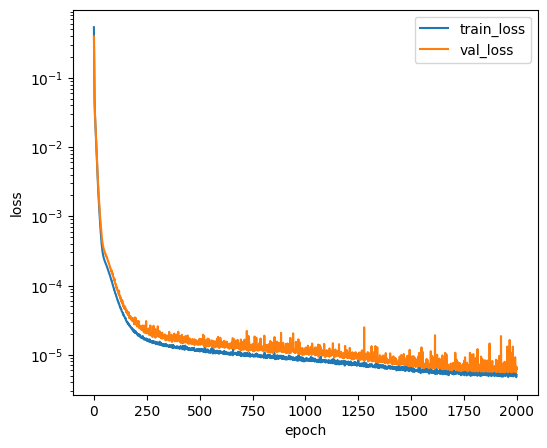

In [78]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(history.history['loss'],label='train_loss')
plt.semilogy(history.history['val_loss'],label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss')
# plt.savefig('FOPDT_loss.png')
plt.legend();

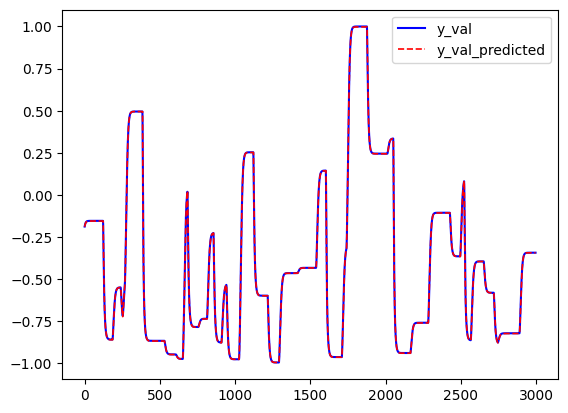

In [79]:
Y_pre = model_ff.predict(X_val);

plt.plot(Y_val[:4000],'b', label='y_val')
plt.plot(Y_pre[:4000],'--r',linewidth=1.2, label='y_val_predicted');
plt.legend();

In [80]:
def predict_nn(u, y, model, window):
    X = np.concatenate((u[:window],y[:window]), axis=1)
    Yp = np.zeros(y.shape); Yp[:window] = y[:window]

    for i in range(window,len(u)):
        yp = model.predict(X.reshape(-1, X.shape[0], X.shape[1]),verbose=0)
        X[:-1] = X[1:]
        X[-1][u.shape[1]:] = yp
        X[-1][:u.shape[1]] = u[i]
        
        Yp[i] = yp
    return Yp

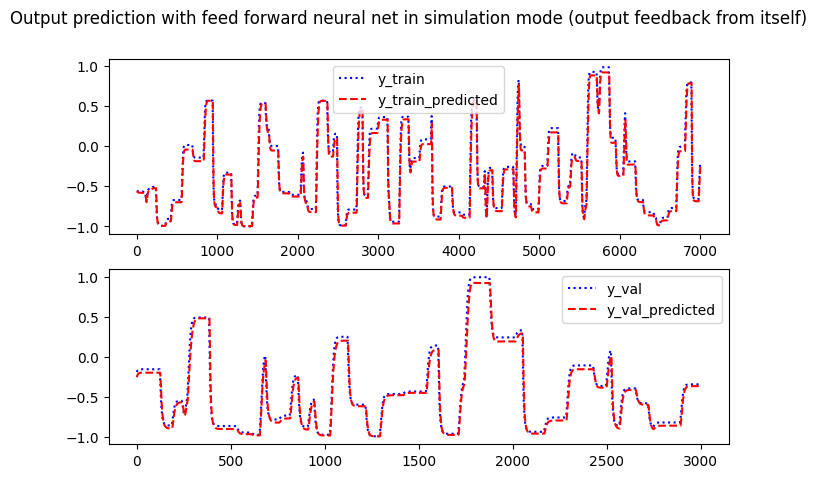

In [81]:
Y_pre_c = predict_nn(u_id_scaled, y_id_scaled, model_ff, window)
fig = plt.figure(figsize=(8,5))
fig.suptitle('Output prediction with feed forward neural net in simulation mode (output feedback from itself)')
plt.subplot(2,1,1)
plt.plot(Y_train,':b',label='y_train')
plt.plot(Y_pre_c[:len(Y_train)],'--r', label='y_train_predicted')
plt.legend();
plt.subplot(2,1,2)
plt.plot(Y_val,':b',label='y_val')
plt.plot(Y_pre_c[len(Y_train):],'--r', label='y_val_predicted')
plt.legend();

In [58]:
model_ff.save('model_ff.h5')

## Declaring MPC object for the Neural Network Model

In [59]:
model_ff = load_model('model_ff.h5')

with open('scalers.pkl', 'rb') as file:
    scalers = pickle.load(file)
s1 = scalers['s1']
s2 = scalers['s2']

In [82]:
def shift_arr(X, val):
    X[:-1] = X[1:]
    X[-1] = val

In [83]:

class NN_MPC():
    """ 
    a class for model predictive calculation based on a neural network 
    model trained using tensorflow
    
    """
    def __init__(self, model, Nc=3, Np=10, Q=1, R=0.1, u_min=-np.inf, u_max=np.inf):
        
        self.model = model
        self.Nc = Nc
        self.Np = Np
        self.q = self.model.output.shape.as_list()[1] # output number
        self.p = self.model.input.shape.as_list()[2] - self.q
        self.model_window = self.model.input.shape.as_list()[1]
        self.Q = Q
        self.R = R
        self.u_min = u_min
        self.u_max = u_max
        self.Xo = np.zeros((self.model_window, self.p + self.q)) # mpc memory for past values of u,y
    
    def memory_update(self, u, y):
        shift_arr(self.Xo, np.append(u,y))
           
    def predict(self, U, y):
        
        Yp = np.zeros((self.Np,self.q))
        X = self.Xo.copy() # input matrix to nn model
        
        yp = self.model.predict(X.reshape(-1, X.shape[0], X.shape[1]), verbose=0)
        d = y - yp # estimated disturbance and model mismatch to consider in prediction horizon
        val = np.zeros(self.p+self.q)
        yp = y # initialize yp in current moment with plant output y
        for i in range(self.Np):
            
            val[:self.p] = U[i,:]
            val[self.p:] = yp      
            shift_arr(X, val)
            
            yp = self.model.predict(X.reshape(-1, X.shape[0], X.shape[1]), verbose=0) + d
            Yp[i] = yp
            
        return Yp
        
         
    def obj(self, U, y_sp, y):
        
        Ysp = y_sp*np.ones((self.Np,self.q))
        U_Np = np.zeros((self.Np,self.p))
        U = U.reshape((self.Nc,self.p))
        U_Np[:self.Nc] = U
        U_Np[self.Nc:] = U[-1]
        Yp = self.predict(U_Np, y)
        dU = U - np.append(self.Xo[-1,:self.p], U[:-1])
        
        J = np.sum((Yp-Ysp)**2)*self.Q + np.sum(dU**2)*self.R

        return J
        
    def calc(self, y_sp, y):
        lb = [self.u_min for i in range(self.Nc)]
        ub = [self.u_max for i in range(self.Nc)]
        bounds = Bounds(lb,ub)
        U0 = np.zeros((self.Nc,self.p))
        U0[:] = self.Xo[-1,:self.p]

        U0 = U0.flatten()

        sol = minimize(self.obj, U0, method='SLSQP', options={'disp': False}, 
                       jac='3-point', args=(y_sp, y), bounds=bounds)
        u = sol.x.reshape((self.Nc,self.p))[0] #U0[0]  # receding horizon

        self.memory_update(u, y)
        
        return u
        
        

## Using NMPC to Control The Dynamic System

In [89]:
# 1. select sample time
t_f = 2.4
# dt = 0.02
x0 = np.array([ 5.37459607e+00, 2.24331334e-01, 3.13082074e-03, 6.26162513e+01 ])
u0 = 0.028328

t = np.arange(0,t_f,dt)
mpc = NN_MPC(model_ff, Q=1, R=0.01, Np=10, Nc=3, u_min=-1, u_max=1 )

# 2. create a process instance
model = ode_model_simulator(dt,x0, ode_function)

# 3. get initial condition
x = [model.send(None)]
u_s = s1.transform(np.array([u0]).reshape(-1, 1))
y_s =  s2.transform((x0[3]/x0[2]/10000).reshape(-1, 1))
data = []
mpc.Xo[:] = np.array([u_s,y_s]).reshape(1,2)
y_sp = np.zeros((int(t_f/dt),len(y_s)))

# set point profile
y_sp[:] = y_s
y_sp[20:] = 0.7*y_s
y_sp[60:] = 1.3*y_s

# 4. simulation of system with an mpc controller
for i in range(int(t_f/dt)):
    
    # give the mpc algorithm current data
    u_s = mpc.calc(y_sp[i], y_s)
    
    # unormalize u_s
    u = s1.inverse_transform(u_s.reshape(-1, 1))
    
    # send the calculated input to the plant
    x = model.send(u)
    
    y = x[3]/x[2]/10000
    data.append([u,y])
 
    # normalize y for the next time step
    y_s = s2.transform(y.reshape(-1, 1))


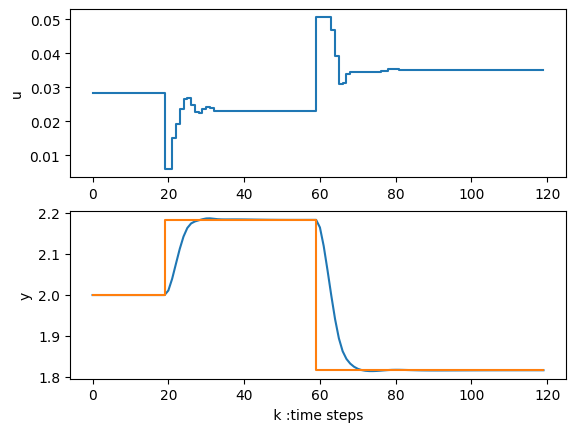

In [97]:
u_data = [data[i][0][0] for i in range(len(data))]
y_data = [data[i][1] for i in range(len(data))]
plt.subplot(2,1,1)
plt.ylabel('u')
plt.step(np.arange(len(y_sp)),u_data);
plt.subplot(2,1,2)
plt.ylabel('y')
plt.xlabel(' k :time steps ')
plt.plot(y_data)
plt.step(np.arange(len(y_sp)),s2.inverse_transform(y_sp));